<a href="https://colab.research.google.com/github/esis-a-i/HSE-DeepLearning/blob/main/HW/HW2_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 2. Классификация при помощи CNN.

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим?

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [2]:
# Для тру нормализации
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

100%|██████████| 170M/170M [00:12<00:00, 13.1MB/s]


Посмотрим на изображения:

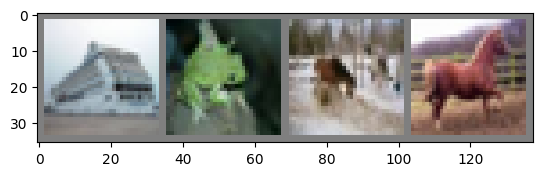

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        # <your code here>
        self.initial_conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.initial_bn = nn.BatchNorm2d(32)
        self.initial_relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.avg = nn.AdaptiveAvgPool2d((4, 4))
        self.relu2 = nn.ReLU()
        self.classifier = nn.Linear(512, n_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.initial_relu(x)

        y = self.conv1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv3(x)
        x = self.bn2(x)
        out = y + x
        out = self.relu2(out)
        out = self.avg(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)

        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (initial_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (initial_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (initial_relu): ReLU()
  (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg): AdaptiveAvgPool2d(output_size=(4, 4))
  (relu2): ReLU()
  (classifier): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
from tqdm import tqdm

def test(model, loader):
    loss_log = []
    acc_log = []
    criterion = nn.CrossEntropyLoss()
    model.eval()

    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        # <your code here>
        out = model(data)
        loss = criterion(out, target)

        loss_log.append(loss.item())

        # <your code here>
        predicted = torch.argmax(out.data, 1)
        acc = (predicted == target).sum().item() / target.size(0)
        acc_log.append(acc)

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    criterion = nn.CrossEntropyLoss()
    model.train()

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        # <your code here>
        out = model(data)
        loss = criterion(out, target)
        loss_log.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # <your code here>
        predicted = torch.argmax(out.data, 1)
        acc = (predicted == target).sum().item() / target.size(0)
        acc_log.append(acc)

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

  5%|▌         | 1/20 [00:14<04:29, 14.18s/it]

Epoch 0
 train loss: 1.4443260710243768, train acc: 0.4843097088012536
 val loss: 1.3184601552942965, val acc: 0.536258865248227



 10%|█         | 2/20 [00:28<04:12, 14.03s/it]

Epoch 1
 train loss: 1.0958015231153428, train acc: 0.6146921519979106
 val loss: 1.0505675835812345, val acc: 0.6388519503546098



 15%|█▌        | 3/20 [00:42<03:57, 13.98s/it]

Epoch 2
 train loss: 0.9759657318674886, train acc: 0.6581597675633325
 val loss: 1.007783605950944, val acc: 0.6442154255319149



 20%|██        | 4/20 [00:56<03:49, 14.34s/it]

Epoch 3
 train loss: 0.9114969818966916, train acc: 0.6829785844868111
 val loss: 0.9786380141339404, val acc: 0.667265070921986



 25%|██▌       | 5/20 [01:12<03:39, 14.61s/it]

Epoch 4
 train loss: 0.8605084820247002, train acc: 0.7003174784539045
 val loss: 0.9008762095836883, val acc: 0.6851950354609928



 30%|███       | 6/20 [01:26<03:21, 14.41s/it]

Epoch 5
 train loss: 0.8207147291961928, train acc: 0.7165178571428572
 val loss: 0.8613345546925322, val acc: 0.7011303191489362



 35%|███▌      | 7/20 [01:40<03:05, 14.28s/it]

Epoch 6
 train loss: 0.7908018079383717, train acc: 0.7244425763907025
 val loss: 0.8921119509859288, val acc: 0.6929521276595745



 40%|████      | 8/20 [01:55<02:57, 14.76s/it]

Epoch 7
 train loss: 0.7669677107817948, train acc: 0.7333629864194307
 val loss: 0.8966484612606941, val acc: 0.694392730496454



 45%|████▌     | 9/20 [02:12<02:48, 15.32s/it]

Epoch 8
 train loss: 0.7484433261415422, train acc: 0.740785779576913
 val loss: 0.8238930418136272, val acc: 0.7185062056737588



 50%|█████     | 10/20 [02:28<02:34, 15.50s/it]

Epoch 9
 train loss: 0.7285506485585103, train acc: 0.7463763384695743
 val loss: 0.8183709894088989, val acc: 0.7205673758865248



 55%|█████▌    | 11/20 [02:42<02:15, 15.07s/it]

Epoch 10
 train loss: 0.7039273786043554, train acc: 0.7548152259075477
 val loss: 0.8494651949152033, val acc: 0.7087322695035461



 60%|██████    | 12/20 [02:56<01:58, 14.75s/it]

Epoch 11
 train loss: 0.6906660986992733, train acc: 0.7597324693131366
 val loss: 0.8336146301411568, val acc: 0.7160460992907801



 65%|██████▌   | 13/20 [03:10<01:41, 14.49s/it]

Epoch 12
 train loss: 0.6703985602589805, train acc: 0.7689589318359885
 val loss: 0.7868288561384729, val acc: 0.7357712765957447



 70%|███████   | 14/20 [03:24<01:26, 14.35s/it]

Epoch 13
 train loss: 0.6610130637175858, train acc: 0.7702933207103683
 val loss: 0.7718432544393742, val acc: 0.7372118794326242



 75%|███████▌  | 15/20 [03:38<01:11, 14.27s/it]

Epoch 14
 train loss: 0.6475077016480009, train acc: 0.7741006137372682
 val loss: 0.8084670965975903, val acc: 0.728235815602837



 80%|████████  | 16/20 [03:54<00:58, 14.68s/it]

Epoch 15
 train loss: 0.6389988928324998, train acc: 0.7754064377121964
 val loss: 0.8100950346348134, val acc: 0.7309840425531915



 85%|████████▌ | 17/20 [04:08<00:43, 14.53s/it]

Epoch 16
 train loss: 0.6275212346853678, train acc: 0.7803359232175503
 val loss: 0.7822834504411575, val acc: 0.7343971631205672



 90%|█████████ | 18/20 [04:22<00:28, 14.44s/it]

Epoch 17
 train loss: 0.6184132086075638, train acc: 0.7843309284408463
 val loss: 0.8989138461173849, val acc: 0.7033244680851064



 95%|█████████▌| 19/20 [04:36<00:14, 14.26s/it]

Epoch 18
 train loss: 0.6042005640115773, train acc: 0.789950052232959
 val loss: 0.7925111529674936, val acc: 0.7401152482269503



100%|██████████| 20/20 [04:50<00:00, 14.52s/it]

Epoch 19
 train loss: 0.5948109703591362, train acc: 0.7915986550013058
 val loss: 0.7919600334573299, val acc: 0.736968085106383



Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>
_, acc = test(net, test_loader)
acc

np.float64(0.7306926751592356)

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

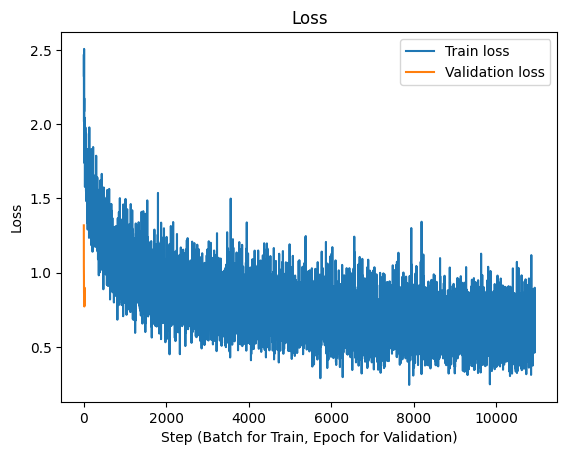

In [ ]:
# <your code here>
import matplotlib.pyplot as plt

train_steps = range(len(train_loss_log))
val_steps = range(len(val_loss_log))

plt.plot(train_steps, train_loss_log, label="Train loss")
plt.plot(val_steps, val_loss_log, label="Validation loss")
plt.title("Loss")
plt.xlabel("Step (Batch for Train, Epoch for Validation)")
plt.ylabel("Loss")
plt.legend()

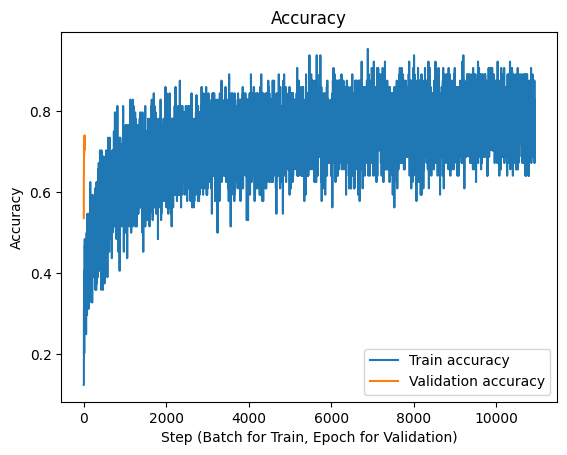

In [ ]:
plt.plot(train_steps, train_acc_log, label="Train accuracy")
plt.plot(val_steps, val_acc_log, label="Validation accuracy")
plt.title("Accuracy")
plt.xlabel("Step (Batch for Train, Epoch for Validation)")
plt.ylabel("Accuracy")
plt.legend()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

  5%|▌         | 1/20 [00:14<04:37, 14.63s/it]

Epoch 0
 train loss: 1.4755835537500748, train acc: 0.46699529903369025
 val loss: 1.2551304817199707, val acc: 0.5606382978723404



 10%|█         | 2/20 [00:28<04:17, 14.28s/it]

Epoch 1
 train loss: 1.1212601211650717, train acc: 0.6053759140767825
 val loss: 1.0747999170993237, val acc: 0.6207668439716312



 15%|█▌        | 3/20 [00:42<03:57, 13.97s/it]

Epoch 2
 train loss: 1.0131087819662565, train acc: 0.6447873139200836
 val loss: 0.9998795273456168, val acc: 0.6523714539007093



 20%|██        | 4/20 [00:55<03:41, 13.85s/it]

Epoch 3
 train loss: 0.9442187137969887, train acc: 0.6684472120658135
 val loss: 0.997047389060893, val acc: 0.6561170212765958



 25%|██▌       | 5/20 [01:09<03:27, 13.81s/it]

Epoch 4
 train loss: 0.9052526621757522, train acc: 0.6848108187516323
 val loss: 0.9197347590263854, val acc: 0.6797872340425531



 30%|███       | 6/20 [01:23<03:12, 13.75s/it]

Epoch 5
 train loss: 0.852620605903744, train acc: 0.6995054191694959
 val loss: 0.8929002700967992, val acc: 0.6849512411347518



 35%|███▌      | 7/20 [01:37<02:58, 13.76s/it]

Epoch 6
 train loss: 0.8257994838127053, train acc: 0.7121637503264561
 val loss: 0.8720078422668133, val acc: 0.6972739361702127



 40%|████      | 8/20 [01:50<02:45, 13.77s/it]

Epoch 7
 train loss: 0.7951642430678582, train acc: 0.7227776508226691
 val loss: 0.8436899289171746, val acc: 0.7092420212765957



 45%|████▌     | 9/20 [02:05<02:33, 13.96s/it]

Epoch 8
 train loss: 0.7746414477907979, train acc: 0.7291190585009141
 val loss: 0.9652348716208276, val acc: 0.6785017730496454



 50%|█████     | 10/20 [02:19<02:19, 13.92s/it]

Epoch 9
 train loss: 0.7510021947310656, train acc: 0.7377701423348133
 val loss: 0.8684768412975554, val acc: 0.707734929078014



 55%|█████▌    | 11/20 [02:33<02:06, 14.06s/it]

Epoch 10
 train loss: 0.6230187615485252, train acc: 0.7858448681117786
 val loss: 0.7418438694578536, val acc: 0.7476063829787234



 60%|██████    | 12/20 [02:47<01:52, 14.06s/it]

Epoch 11
 train loss: 0.6001909822497987, train acc: 0.7929942543745102
 val loss: 0.7354012589505379, val acc: 0.752127659574468



 65%|██████▌   | 13/20 [03:01<01:38, 14.02s/it]

Epoch 12
 train loss: 0.5904363867242768, train acc: 0.7972871506920868
 val loss: 0.7343189079710778, val acc: 0.7519946808510638



 70%|███████   | 14/20 [03:15<01:23, 13.97s/it]

Epoch 13
 train loss: 0.584190829798334, train acc: 0.8000253003395142
 val loss: 0.7359921862470343, val acc: 0.7507757092198583



 75%|███████▌  | 15/20 [03:29<01:09, 13.94s/it]

Epoch 14
 train loss: 0.5782268993706329, train acc: 0.8002783037346565
 val loss: 0.7314768122865799, val acc: 0.7546985815602838



 80%|████████  | 16/20 [03:43<00:55, 13.95s/it]

Epoch 15
 train loss: 0.5577682086710956, train acc: 0.8085743666753721
 val loss: 0.7245350364674913, val acc: 0.755075354609929



 85%|████████▌ | 17/20 [03:57<00:41, 13.93s/it]

Epoch 16
 train loss: 0.556135487294938, train acc: 0.8104514886393314
 val loss: 0.7255215764045715, val acc: 0.7552969858156029



 90%|█████████ | 18/20 [04:10<00:27, 13.88s/it]

Epoch 17
 train loss: 0.5534119898048135, train acc: 0.8096394293549231
 val loss: 0.7242614931248604, val acc: 0.7565381205673758



 95%|█████████▌| 19/20 [04:24<00:13, 13.91s/it]

Epoch 18
 train loss: 0.5540191428208046, train acc: 0.8089293875685558
 val loss: 0.7246778374022625, val acc: 0.7557402482269503



100%|██████████| 20/20 [04:39<00:00, 13.96s/it]

Epoch 19
 train loss: 0.5533974952519048, train acc: 0.8100597414468529
 val loss: 0.7247952153073981, val acc: 0.7560726950354609



Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>
_, acc = test(net, test_loader)
acc

np.float64(0.746218152866242)

на 1 процент выше, чем без него

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
# <your code here>
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
_, acc = test(net, test_loader)
acc

  5%|▌         | 1/20 [00:13<04:22, 13.80s/it]

Epoch 0
 train loss: 1.7524634440594662, train acc: 0.3806803342909376
 val loss: 1.5203532721133943, val acc: 0.45571808510638295



 10%|█         | 2/20 [00:27<04:09, 13.83s/it]

Epoch 1
 train loss: 1.4197344352819803, train acc: 0.4977066466440324
 val loss: 1.3394803731999498, val acc: 0.5282358156028369



 15%|█▌        | 3/20 [00:42<04:01, 14.21s/it]

Epoch 2
 train loss: 1.294808816757237, train acc: 0.5441694959519456
 val loss: 1.2875473316679609, val acc: 0.5392730496453901



 20%|██        | 4/20 [00:57<03:50, 14.41s/it]

Epoch 3
 train loss: 1.2189124890175773, train acc: 0.5716040415252024
 val loss: 1.213393762263846, val acc: 0.5702570921985817



 25%|██▌       | 5/20 [01:10<03:33, 14.25s/it]

Epoch 4
 train loss: 1.1455689123823176, train acc: 0.5958107534604334
 val loss: 1.1306181329361935, val acc: 0.5958998226950354



 30%|███       | 6/20 [01:24<03:17, 14.10s/it]

Epoch 5
 train loss: 1.0875776343633314, train acc: 0.6173976560459651
 val loss: 1.0719222286914258, val acc: 0.6185726950354609



 35%|███▌      | 7/20 [01:38<03:03, 14.09s/it]

Epoch 6
 train loss: 1.0375886123620615, train acc: 0.6366830438756855
 val loss: 1.0269968248428183, val acc: 0.6375886524822694



 40%|████      | 8/20 [01:52<02:48, 14.04s/it]

Epoch 7
 train loss: 1.001659601763354, train acc: 0.6492475189344477
 val loss: 1.006378501526853, val acc: 0.6432402482269503



 45%|████▌     | 9/20 [02:06<02:34, 14.04s/it]

Epoch 8
 train loss: 0.9699662446539842, train acc: 0.6604939279185166
 val loss: 0.9643830497214134, val acc: 0.6582890070921986



 50%|█████     | 10/20 [02:20<02:20, 14.07s/it]

Epoch 9
 train loss: 0.9448372453614606, train acc: 0.6705691760250718
 val loss: 1.008129149548551, val acc: 0.6482712765957447



 55%|█████▌    | 11/20 [02:35<02:08, 14.28s/it]

Epoch 10
 train loss: 0.9240562525702133, train acc: 0.6782939409767563
 val loss: 0.9814795532125108, val acc: 0.6560062056737588



 60%|██████    | 12/20 [02:49<01:54, 14.27s/it]

Epoch 11
 train loss: 0.9065625987933367, train acc: 0.6830520370854009
 val loss: 0.954987655801976, val acc: 0.6645168439716311



 65%|██████▌   | 13/20 [03:03<01:39, 14.17s/it]

Epoch 12
 train loss: 0.8858408759019493, train acc: 0.6930415904936015
 val loss: 0.8921096007874671, val acc: 0.6867464539007093



 70%|███████   | 14/20 [03:17<01:24, 14.09s/it]

Epoch 13
 train loss: 0.8703839191571014, train acc: 0.6983791459911205
 val loss: 0.8990001967612733, val acc: 0.68707890070922



 75%|███████▌  | 15/20 [03:31<01:10, 14.04s/it]

Epoch 14
 train loss: 0.8582774407793878, train acc: 0.70354531209193
 val loss: 0.8796424865722656, val acc: 0.6903590425531915



 80%|████████  | 16/20 [03:45<00:56, 14.04s/it]

Epoch 15
 train loss: 0.8412456016653852, train acc: 0.7079647101070776
 val loss: 0.8613242428353493, val acc: 0.7002659574468085



 85%|████████▌ | 17/20 [03:59<00:41, 13.99s/it]

Epoch 16
 train loss: 0.8303951641759227, train acc: 0.7115434839383651
 val loss: 0.8637563170270717, val acc: 0.7003767730496455



 90%|█████████ | 18/20 [04:13<00:27, 13.99s/it]

Epoch 17
 train loss: 0.822576219028703, train acc: 0.7161261099503786
 val loss: 0.8665109210825981, val acc: 0.6938386524822694



 95%|█████████▌| 19/20 [04:28<00:14, 14.09s/it]

Epoch 18
 train loss: 0.8120990718086634, train acc: 0.7162199660485766
 val loss: 0.8425902036910361, val acc: 0.7082668439716311



100%|██████████| 20/20 [04:42<00:00, 14.13s/it]

Epoch 19
 train loss: 0.8016486668608525, train acc: 0.7213004374510316
 val loss: 0.8260645785230272, val acc: 0.7128989361702127



np.float64(0.7104896496815286)

получилось действительно хуже (на 3 процента)

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [14]:
# <your code here>
# есть CosineAnnealingLR, он позволяет менять lr по косинусу, что позволяет модели колебаться рядом с оптимумом (T_max=20, так как у нас 20 эпох, мы пройдем полный цикл 1 раза)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
_, acc = test(net, test_loader)
acc

  5%|▌         | 1/20 [00:14<04:35, 14.51s/it]

Epoch 0
 train loss: 1.4688448631349387, train acc: 0.4734591277095848
 val loss: 1.1850928798634954, val acc: 0.5855053191489362



 10%|█         | 2/20 [00:28<04:20, 14.47s/it]

Epoch 1
 train loss: 1.1123130698526582, train acc: 0.6123702337424916
 val loss: 1.0475804549582461, val acc: 0.627238475177305



 15%|█▌        | 3/20 [00:43<04:05, 14.45s/it]

Epoch 2
 train loss: 0.9849619358723517, train acc: 0.655397133716375
 val loss: 0.9899742283719651, val acc: 0.6591976950354609



 20%|██        | 4/20 [00:58<03:52, 14.55s/it]

Epoch 3
 train loss: 0.9182169575795831, train acc: 0.6822644620005224
 val loss: 0.9614167129739802, val acc: 0.6687278368794327



 25%|██▌       | 5/20 [01:13<03:41, 14.80s/it]

Epoch 4
 train loss: 0.8658982881462334, train acc: 0.6990279772786628
 val loss: 0.8806843429169756, val acc: 0.6935283687943263



 30%|███       | 6/20 [01:30<03:40, 15.72s/it]

Epoch 5
 train loss: 0.8266359732726374, train acc: 0.7129472447114129
 val loss: 0.9450316616829405, val acc: 0.6763962765957446



 35%|███▌      | 7/20 [01:45<03:18, 15.28s/it]

Epoch 6
 train loss: 0.7801306855743938, train acc: 0.7286048903107861
 val loss: 0.8535405547060865, val acc: 0.7090425531914893



 40%|████      | 8/20 [01:59<03:00, 15.05s/it]

Epoch 7
 train loss: 0.7449593866547022, train acc: 0.7422833964481589
 val loss: 0.8678101894703317, val acc: 0.7042109929078013



 45%|████▌     | 9/20 [02:14<02:45, 15.06s/it]

Epoch 8
 train loss: 0.7175103613401898, train acc: 0.7499551123008619
 val loss: 0.8471273735482642, val acc: 0.7102393617021276



 50%|█████     | 10/20 [02:31<02:36, 15.64s/it]

Epoch 9
 train loss: 0.6885151884346601, train acc: 0.7610505353878297
 val loss: 0.7816157406948983, val acc: 0.7330452127659575



 55%|█████▌    | 11/20 [02:48<02:22, 15.84s/it]

Epoch 10
 train loss: 0.6571560840393115, train acc: 0.7716807586837294
 val loss: 0.7868780805709514, val acc: 0.7297872340425532



 60%|██████    | 12/20 [03:02<02:04, 15.52s/it]

Epoch 11
 train loss: 0.6283889564888133, train acc: 0.7804052951162184
 val loss: 0.7629398794884378, val acc: 0.7407801418439716



 65%|██████▌   | 13/20 [03:17<01:46, 15.22s/it]

Epoch 12
 train loss: 0.6047769723361327, train acc: 0.7914599112039697
 val loss: 0.7870097956758865, val acc: 0.7344193262411348



 70%|███████   | 14/20 [03:33<01:33, 15.52s/it]

Epoch 13
 train loss: 0.5781863196131516, train acc: 0.8007598263254113
 val loss: 0.7483983536984058, val acc: 0.7453014184397162



 75%|███████▌  | 15/20 [03:48<01:16, 15.28s/it]

Epoch 14
 train loss: 0.5548360185115385, train acc: 0.8096435100548446
 val loss: 0.7475917461070608, val acc: 0.748293439716312



 80%|████████  | 16/20 [04:02<01:00, 15.04s/it]

Epoch 15
 train loss: 0.5358661954483559, train acc: 0.8152707952468007
 val loss: 0.7355138744445557, val acc: 0.7553856382978723



 85%|████████▌ | 17/20 [04:17<00:44, 14.87s/it]

Epoch 16
 train loss: 0.5158695778528559, train acc: 0.822052918516584
 val loss: 0.7358123812269657, val acc: 0.7563164893617021



 90%|█████████ | 18/20 [04:32<00:29, 14.86s/it]

Epoch 17
 train loss: 0.4997999770004963, train acc: 0.8289329785844868
 val loss: 0.7332221721081024, val acc: 0.7548980496453902



 95%|█████████▌| 19/20 [04:46<00:14, 14.72s/it]

Epoch 18
 train loss: 0.48838272478288447, train acc: 0.8335400887960303
 val loss: 0.7260084112907977, val acc: 0.7576241134751774



100%|██████████| 20/20 [05:00<00:00, 15.05s/it]

Epoch 19
 train loss: 0.48300014199242947, train acc: 0.8347561373726821
 val loss: 0.7236966153408618, val acc: 0.7599069148936171



np.float64(0.7534832802547771)

получится хороший результат, выше чем у MultiStepLR

In [15]:
# ExponentialLR, экспоненциально уменьшает lr после каждой эпохи (lr_new = lr_old ** gamma)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
_, acc = test(net, test_loader)
acc

  5%|▌         | 1/20 [00:14<04:34, 14.45s/it]

Epoch 0
 train loss: 1.5255517345023983, train acc: 0.45197424262209457
 val loss: 1.328648102029841, val acc: 0.5290780141843971



 10%|█         | 2/20 [00:29<04:25, 14.75s/it]

Epoch 1
 train loss: 1.1666124148168338, train acc: 0.590199791068164
 val loss: 1.0975886337300564, val acc: 0.6139627659574468



 15%|█▌        | 3/20 [00:44<04:11, 14.78s/it]

Epoch 2
 train loss: 1.0245971300484276, train acc: 0.6391437059284408
 val loss: 0.9927440853829079, val acc: 0.6512411347517731



 20%|██        | 4/20 [00:59<04:00, 15.05s/it]

Epoch 3
 train loss: 0.9473324510689409, train acc: 0.6706915970227213
 val loss: 0.9903166547734686, val acc: 0.6536125886524822



 25%|██▌       | 5/20 [01:14<03:43, 14.88s/it]

Epoch 4
 train loss: 0.8837084252612029, train acc: 0.6925396644032384
 val loss: 0.9013152929062539, val acc: 0.6865026595744681



 30%|███       | 6/20 [01:28<03:25, 14.71s/it]

Epoch 5
 train loss: 0.836434591513883, train acc: 0.7092256463828676
 val loss: 0.8832730800547498, val acc: 0.6924867021276596



 35%|███▌      | 7/20 [01:43<03:09, 14.60s/it]

Epoch 6
 train loss: 0.8001487881653487, train acc: 0.7191907155915382
 val loss: 0.8325062640169834, val acc: 0.7153368794326241



 40%|████      | 8/20 [01:57<02:54, 14.53s/it]

Epoch 7
 train loss: 0.764332662389309, train acc: 0.7356808239749282
 val loss: 0.8257757474767401, val acc: 0.712145390070922



 45%|████▌     | 9/20 [02:11<02:39, 14.49s/it]

Epoch 8
 train loss: 0.7337670031478679, train acc: 0.746368177069731
 val loss: 0.8059161434782313, val acc: 0.7184397163120566



 50%|█████     | 10/20 [02:26<02:24, 14.47s/it]

Epoch 9
 train loss: 0.7086433915377099, train acc: 0.7551743275006528
 val loss: 0.7992798422245269, val acc: 0.7291001773049646



 55%|█████▌    | 11/20 [02:41<02:12, 14.74s/it]

Epoch 10
 train loss: 0.6872308630176175, train acc: 0.7628542047531993
 val loss: 0.7791883741287475, val acc: 0.7343085106382978



 60%|██████    | 12/20 [02:55<01:56, 14.60s/it]

Epoch 11
 train loss: 0.6678620597017313, train acc: 0.7692486615304257
 val loss: 0.8023847782865484, val acc: 0.7256648936170212



 65%|██████▌   | 13/20 [03:10<01:41, 14.53s/it]

Epoch 12
 train loss: 0.6455025848348572, train acc: 0.773835368242361
 val loss: 0.7744838505349261, val acc: 0.7373005319148936



 70%|███████   | 14/20 [03:24<01:26, 14.44s/it]

Epoch 13
 train loss: 0.6290053763925703, train acc: 0.7812336772003134
 val loss: 0.7640688878424624, val acc: 0.7422207446808511



 75%|███████▌  | 15/20 [03:38<01:11, 14.35s/it]

Epoch 14
 train loss: 0.6149562399500684, train acc: 0.7873180007834945
 val loss: 0.7505672717348059, val acc: 0.7445478723404255



 80%|████████  | 16/20 [03:53<00:58, 14.53s/it]

Epoch 15
 train loss: 0.6001260773137457, train acc: 0.7909090167145468
 val loss: 0.7479964402127773, val acc: 0.7476728723404256



 85%|████████▌ | 17/20 [04:09<00:45, 15.03s/it]

Epoch 16
 train loss: 0.5860654251884935, train acc: 0.7949693131365891
 val loss: 0.7474153772313544, val acc: 0.7474290780141843



 90%|█████████ | 18/20 [04:24<00:29, 14.83s/it]

Epoch 17
 train loss: 0.5718614924324495, train acc: 0.800576194828937
 val loss: 0.7268144741971442, val acc: 0.7532358156028369



 95%|█████████▌| 19/20 [04:40<00:15, 15.17s/it]

Epoch 18
 train loss: 0.5598450497855216, train acc: 0.8042202598589709
 val loss: 0.7431192573080672, val acc: 0.7471187943262412



100%|██████████| 20/20 [04:54<00:00, 14.74s/it]

Epoch 19
 train loss: 0.5530309055742878, train acc: 0.8070318621049882
 val loss: 0.7328277603108833, val acc: 0.7538563829787234



np.float64(0.7440286624203821)

результат на пол-процента хуже MultiStepLR

лучший результат у lr_scheduler.CosineAnnealingLR

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

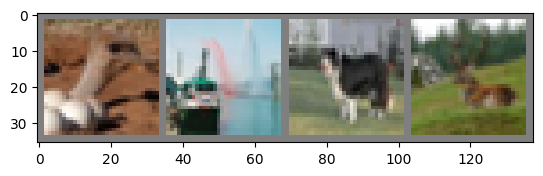

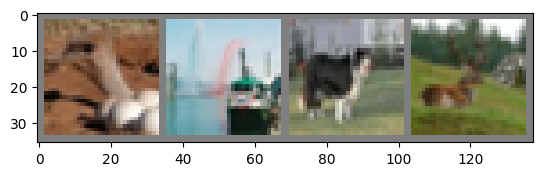

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

  5%|▌         | 1/20 [00:16<05:04, 16.01s/it]

Epoch 0
 train loss: 1.4930516418198998, train acc: 0.4633226691042048
 val loss: 1.392635503728339, val acc: 0.51072695035461



 10%|█         | 2/20 [00:31<04:45, 15.86s/it]

Epoch 1
 train loss: 1.1658845813008505, train acc: 0.5898202859754506
 val loss: 1.1008235563623143, val acc: 0.6125886524822695



 15%|█▌        | 3/20 [00:47<04:31, 15.97s/it]

Epoch 2
 train loss: 1.0428378621228651, train acc: 0.6374094084617394
 val loss: 1.0172970830126011, val acc: 0.6414228723404255



 20%|██        | 4/20 [01:03<04:14, 15.89s/it]

Epoch 3
 train loss: 0.9657808295987423, train acc: 0.6628729759728389
 val loss: 0.9405920546105567, val acc: 0.6750886524822695



 25%|██▌       | 5/20 [01:19<04:00, 16.04s/it]

Epoch 4
 train loss: 0.9254849654447008, train acc: 0.6773104922956386
 val loss: 0.990038377680677, val acc: 0.6656028368794327



 30%|███       | 6/20 [01:35<03:42, 15.89s/it]

Epoch 5
 train loss: 0.8843690569919468, train acc: 0.6912338404283103
 val loss: 0.8549915136174953, val acc: 0.7061170212765957



 35%|███▌      | 7/20 [01:51<03:24, 15.75s/it]

Epoch 6
 train loss: 0.8516892121740407, train acc: 0.7043328871768085
 val loss: 0.8936418431870481, val acc: 0.6932845744680851



 40%|████      | 8/20 [02:06<03:08, 15.68s/it]

Epoch 7
 train loss: 0.8243306827828478, train acc: 0.7128860342125881
 val loss: 0.8759260687422246, val acc: 0.6952349290780141



 45%|████▌     | 9/20 [02:23<02:56, 16.01s/it]

Epoch 8
 train loss: 0.8007179643597856, train acc: 0.723981457299556
 val loss: 0.8389816228379594, val acc: 0.7106382978723405



 50%|█████     | 10/20 [02:38<02:38, 15.84s/it]

Epoch 9
 train loss: 0.7834251235346471, train acc: 0.7292210759989554
 val loss: 0.8350051415727494, val acc: 0.7113696808510638



 55%|█████▌    | 11/20 [02:54<02:21, 15.75s/it]

Epoch 10
 train loss: 0.6771155002457132, train acc: 0.7662656698876992
 val loss: 0.7274867585364808, val acc: 0.7511968085106383



 60%|██████    | 12/20 [03:09<02:05, 15.66s/it]

Epoch 11
 train loss: 0.657195768474007, train acc: 0.7756512797074955
 val loss: 0.7145902073129694, val acc: 0.7526595744680851



 65%|██████▌   | 13/20 [03:26<01:51, 15.92s/it]

Epoch 12
 train loss: 0.6450170307970134, train acc: 0.7792586184382345
 val loss: 0.7119656571682463, val acc: 0.7540780141843971



 70%|███████   | 14/20 [03:41<01:34, 15.78s/it]

Epoch 13
 train loss: 0.6393130059325063, train acc: 0.7819233154870723
 val loss: 0.7077823938207424, val acc: 0.7562721631205673



 75%|███████▌  | 15/20 [03:56<01:18, 15.61s/it]

Epoch 14
 train loss: 0.6356092493647413, train acc: 0.7811602246017237
 val loss: 0.7021821133633878, val acc: 0.7595301418439715



 80%|████████  | 16/20 [04:11<01:01, 15.44s/it]

Epoch 15
 train loss: 0.6167760702221223, train acc: 0.788607501958736
 val loss: 0.6962251068429745, val acc: 0.7595523049645391



 85%|████████▌ | 17/20 [04:27<00:46, 15.51s/it]

Epoch 16
 train loss: 0.6146813966129554, train acc: 0.7895093366414206
 val loss: 0.6955117034151199, val acc: 0.7601728723404255



 90%|█████████ | 18/20 [04:43<00:31, 15.68s/it]

Epoch 17
 train loss: 0.6148172542861436, train acc: 0.7902234591277095
 val loss: 0.6994247302095941, val acc: 0.7578014184397163



 95%|█████████▌| 19/20 [04:59<00:15, 15.59s/it]

Epoch 18
 train loss: 0.6144403087373626, train acc: 0.7893338665447898
 val loss: 0.6964826023325007, val acc: 0.7626329787234043



100%|██████████| 20/20 [05:14<00:00, 15.72s/it]

Epoch 19
 train loss: 0.6126707848399823, train acc: 0.7880443653695482
 val loss: 0.6931413159725514, val acc: 0.7623005319148937



Посчитайте точность на тестовой выборке:

In [ ]:
# <your code here>
_, acc = test(net, test_loader)
acc

np.float64(0.7534832802547771)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [17]:
# <your code here>

# transforms.RandomCrop() в случайном месте вырезает кусок заданным размером
transform = transforms.Compose(
    [
        transforms.RandomCrop(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
_, acc = test(net, test_loader)
acc

  5%|▌         | 1/20 [00:16<05:17, 16.73s/it]

Epoch 0
 train loss: 1.4816012787862496, train acc: 0.469847708278924
 val loss: 1.258065201881084, val acc: 0.5535904255319148



 10%|█         | 2/20 [00:32<04:48, 16.03s/it]

Epoch 1
 train loss: 1.1298295555864435, train acc: 0.6002301514755811
 val loss: 1.0385682582855225, val acc: 0.6381205673758864



 15%|█▌        | 3/20 [00:49<04:38, 16.36s/it]

Epoch 2
 train loss: 1.0004726239706525, train acc: 0.6517326651867329
 val loss: 0.990107683425254, val acc: 0.6564937943262412



 20%|██        | 4/20 [01:07<04:33, 17.07s/it]

Epoch 3
 train loss: 0.9256540551046131, train acc: 0.6774900430921912
 val loss: 0.9431324015272424, val acc: 0.6699024822695034



 25%|██▌       | 5/20 [01:23<04:12, 16.80s/it]

Epoch 4
 train loss: 0.881154754044151, train acc: 0.695428799947767
 val loss: 0.9252428929856483, val acc: 0.6862588652482269



 30%|███       | 6/20 [01:39<03:50, 16.45s/it]

Epoch 5
 train loss: 0.8389002071656082, train acc: 0.708413587098459
 val loss: 0.8723942057883486, val acc: 0.6951684397163119



 35%|███▌      | 7/20 [01:57<03:40, 16.93s/it]

Epoch 6
 train loss: 0.8078148341592967, train acc: 0.7185622878036041
 val loss: 0.8916410014984456, val acc: 0.6923758865248226



 40%|████      | 8/20 [02:14<03:23, 16.97s/it]

Epoch 7
 train loss: 0.7835065661989139, train acc: 0.7272949856359362
 val loss: 0.8408909642950018, val acc: 0.7151817375886524



 45%|████▌     | 9/20 [02:30<03:05, 16.88s/it]

Epoch 8
 train loss: 0.7593781153179392, train acc: 0.7350646382867588
 val loss: 0.8493423294513783, val acc: 0.7068705673758865



 50%|█████     | 10/20 [02:46<02:45, 16.50s/it]

Epoch 9
 train loss: 0.7383412553143893, train acc: 0.7407082462784017
 val loss: 0.8583384394645691, val acc: 0.7085771276595745



 55%|█████▌    | 11/20 [03:03<02:28, 16.48s/it]

Epoch 10
 train loss: 0.6150069116892283, train acc: 0.7874485831809872
 val loss: 0.7363201625803684, val acc: 0.7480274822695034



 60%|██████    | 12/20 [03:19<02:12, 16.60s/it]

Epoch 11
 train loss: 0.592739948951784, train acc: 0.794479629145991
 val loss: 0.7277962211598741, val acc: 0.7500886524822694



 65%|██████▌   | 13/20 [03:37<01:59, 17.01s/it]

Epoch 12
 train loss: 0.5837483479074412, train acc: 0.7969117262992949
 val loss: 0.7279889764937949, val acc: 0.7500664893617022



 70%|███████   | 14/20 [03:54<01:40, 16.81s/it]

Epoch 13
 train loss: 0.576053625105504, train acc: 0.8010209911203969
 val loss: 0.7253436843131451, val acc: 0.7507092198581561



 75%|███████▌  | 15/20 [04:10<01:22, 16.52s/it]

Epoch 14
 train loss: 0.5725807055040949, train acc: 0.8014617067119352
 val loss: 0.7226401318895056, val acc: 0.7532358156028369



 80%|████████  | 16/20 [04:25<01:05, 16.25s/it]

Epoch 15
 train loss: 0.5519239621362912, train acc: 0.809206875163228
 val loss: 0.7180382032343682, val acc: 0.7540780141843971



 85%|████████▌ | 17/20 [04:44<00:50, 16.88s/it]

Epoch 16
 train loss: 0.5504755947119139, train acc: 0.8102596957430138
 val loss: 0.717898841994874, val acc: 0.7535460992907801



 90%|█████████ | 18/20 [04:59<00:33, 16.50s/it]

Epoch 17
 train loss: 0.5490410877102254, train acc: 0.810304583442152
 val loss: 0.7189755192462434, val acc: 0.7545877659574468



 95%|█████████▌| 19/20 [05:15<00:16, 16.21s/it]

Epoch 18
 train loss: 0.5473341684672689, train acc: 0.8110227866283625
 val loss: 0.7188412255429207, val acc: 0.7545212765957446



100%|██████████| 20/20 [05:30<00:00, 16.53s/it]

Epoch 19
 train loss: 0.5473191416677653, train acc: 0.8129447962914599
 val loss: 0.7177447523208375, val acc: 0.7548758865248226



np.float64(0.7446257961783439)

не дает прироста, даже хуже чем без аугументации результат, возможно 32 слишком много (видно, что на валидации и трэин большой разрыв)

In [18]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
_, acc = test(net, test_loader)
acc

  5%|▌         | 1/20 [00:19<06:17, 19.88s/it]

Epoch 0
 train loss: 1.487322665982534, train acc: 0.4686969509010185
 val loss: 1.363718797298188, val acc: 0.5139627659574468



 10%|█         | 2/20 [00:38<05:45, 19.21s/it]

Epoch 1
 train loss: 1.1592507960591498, train acc: 0.592301351527814
 val loss: 1.0625994012710895, val acc: 0.6321586879432625



 15%|█▌        | 3/20 [00:56<05:18, 18.73s/it]

Epoch 2
 train loss: 1.0366042777214888, train acc: 0.6392661269260904
 val loss: 1.0156618998405782, val acc: 0.6427748226950354



 20%|██        | 4/20 [01:13<04:49, 18.08s/it]

Epoch 3
 train loss: 0.9612911729315735, train acc: 0.6637176808566205
 val loss: 0.9317957089302388, val acc: 0.6779476950354609



 25%|██▌       | 5/20 [01:31<04:28, 17.90s/it]

Epoch 4
 train loss: 0.9168795950887844, train acc: 0.6818767955079654
 val loss: 0.9469103879116951, val acc: 0.6749113475177306



 30%|███       | 6/20 [01:49<04:10, 17.91s/it]

Epoch 5
 train loss: 0.8760347500906566, train acc: 0.6968652063201881
 val loss: 0.8672906988478721, val acc: 0.6986258865248226



 35%|███▌      | 7/20 [02:06<03:50, 17.74s/it]

Epoch 6
 train loss: 0.8438064295260518, train acc: 0.7056795181509533
 val loss: 0.934359868790241, val acc: 0.6742242907801418



 40%|████      | 8/20 [02:26<03:41, 18.45s/it]

Epoch 7
 train loss: 0.8213221646532062, train acc: 0.716566825541917
 val loss: 0.8334076792635816, val acc: 0.7139849290780141



 45%|████▌     | 9/20 [02:43<03:18, 18.08s/it]

Epoch 8
 train loss: 0.7984040758182623, train acc: 0.7231734787150693
 val loss: 0.8407493078962286, val acc: 0.7086436170212767



 50%|█████     | 10/20 [03:03<03:04, 18.49s/it]

Epoch 9
 train loss: 0.7838601906404199, train acc: 0.729319012797075
 val loss: 0.847704978445743, val acc: 0.7063386524822695



 55%|█████▌    | 11/20 [03:22<02:49, 18.78s/it]

Epoch 10
 train loss: 0.675019745090108, train acc: 0.766677820579786
 val loss: 0.7241426518622865, val acc: 0.7515957446808511



 60%|██████    | 12/20 [03:41<02:28, 18.61s/it]

Epoch 11
 train loss: 0.6576155492766902, train acc: 0.7737537542439279
 val loss: 0.7133517394674586, val acc: 0.7548093971631205



 65%|██████▌   | 13/20 [03:58<02:08, 18.38s/it]

Epoch 12
 train loss: 0.6490121975786289, train acc: 0.7748351397231653
 val loss: 0.712517989569522, val acc: 0.7521498226950354



 70%|███████   | 14/20 [04:16<01:49, 18.27s/it]

Epoch 13
 train loss: 0.6404996944192994, train acc: 0.7793279903369026
 val loss: 0.7132763782714275, val acc: 0.7529033687943263



 75%|███████▌  | 15/20 [04:34<01:30, 18.02s/it]

Epoch 14
 train loss: 0.6373924408142048, train acc: 0.7809480282057979
 val loss: 0.7028219725223298, val acc: 0.7558732269503545



 80%|████████  | 16/20 [04:51<01:11, 17.78s/it]

Epoch 15
 train loss: 0.6198807522736258, train acc: 0.7858611909114651
 val loss: 0.6972608047596952, val acc: 0.7585106382978724



 85%|████████▌ | 17/20 [05:10<00:54, 18.06s/it]

Epoch 16
 train loss: 0.6199460349418563, train acc: 0.7859428049098981
 val loss: 0.6976464858714571, val acc: 0.7586214539007093



 90%|█████████ | 18/20 [05:27<00:35, 17.85s/it]

Epoch 17
 train loss: 0.6226340100250907, train acc: 0.7836249673544006
 val loss: 0.6983601788257031, val acc: 0.7569813829787234



 95%|█████████▌| 19/20 [05:45<00:17, 17.90s/it]

Epoch 18
 train loss: 0.6180064065255892, train acc: 0.7869670605902324
 val loss: 0.6943489773476378, val acc: 0.7613031914893617



100%|██████████| 20/20 [06:03<00:00, 18.16s/it]

Epoch 19
 train loss: 0.6188590462290608, train acc: 0.7859428049098981
 val loss: 0.6929402493415995, val acc: 0.7599512411347519



np.float64(0.757265127388535)

комбинация лучше, чем только transforms.RandomCrop(32), но хуже, чем только RandomHorizontalFlip

In [19]:
# transforms.ColorJitter() случайным образом изменяет яркость, контраст, насыщенность и оттенок изображения

transform = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
_, acc = test(net, test_loader)
acc

  5%|▌         | 1/20 [00:38<12:19, 38.90s/it]

Epoch 0
 train loss: 1.5221684972808391, train acc: 0.45478992556803344
 val loss: 1.3506720479498517, val acc: 0.5255319148936171



 10%|█         | 2/20 [01:14<11:06, 37.01s/it]

Epoch 1
 train loss: 1.165222089186011, train acc: 0.5919748955340821
 val loss: 1.085179725099117, val acc: 0.6203235815602838



 15%|█▌        | 3/20 [01:51<10:25, 36.81s/it]

Epoch 2
 train loss: 1.0540748805189046, train acc: 0.6317780425698616
 val loss: 1.004851046267976, val acc: 0.6497783687943263



 20%|██        | 4/20 [02:26<09:41, 36.34s/it]

Epoch 3
 train loss: 0.975212723289155, train acc: 0.6604082332201618
 val loss: 0.9663923524795694, val acc: 0.6664893617021277



 25%|██▌       | 5/20 [03:01<08:55, 35.70s/it]

Epoch 4
 train loss: 0.9294676121453699, train acc: 0.676592289109428
 val loss: 0.9735231625272872, val acc: 0.6632092198581561



 30%|███       | 6/20 [03:36<08:18, 35.58s/it]

Epoch 5
 train loss: 0.883803210703067, train acc: 0.692731457299556
 val loss: 0.9121559528594322, val acc: 0.6893395390070923



 35%|███▌      | 7/20 [04:12<07:43, 35.64s/it]

Epoch 6
 train loss: 0.8502622558386278, train acc: 0.7057325672499347
 val loss: 0.9836356520652771, val acc: 0.6606161347517732



 40%|████      | 8/20 [04:48<07:07, 35.62s/it]

Epoch 7
 train loss: 0.8270014489045745, train acc: 0.7146080895795247
 val loss: 0.920385465723403, val acc: 0.685017730496454



 45%|████▌     | 9/20 [05:24<06:34, 35.82s/it]

Epoch 8
 train loss: 0.8066752735504938, train acc: 0.718260316009402
 val loss: 0.8994814794114295, val acc: 0.6972739361702127



 50%|█████     | 10/20 [05:58<05:54, 35.45s/it]

Epoch 9
 train loss: 0.7784568458741065, train acc: 0.7298250195873597
 val loss: 0.8639460237736397, val acc: 0.6998226950354609



 55%|█████▌    | 11/20 [06:34<05:20, 35.57s/it]

Epoch 10
 train loss: 0.6662411487080715, train acc: 0.7693057913293289
 val loss: 0.7704688942178767, val acc: 0.7383421985815604



 60%|██████    | 12/20 [07:11<04:46, 35.85s/it]

Epoch 11
 train loss: 0.6432250837303385, train acc: 0.7791157939409767
 val loss: 0.7605481766639872, val acc: 0.7407801418439716



 65%|██████▌   | 13/20 [07:47<04:12, 36.04s/it]

Epoch 12
 train loss: 0.633392766227016, train acc: 0.7819682031862104
 val loss: 0.7549524428996633, val acc: 0.7398714539007093



 70%|███████   | 14/20 [08:24<03:36, 36.14s/it]

Epoch 13
 train loss: 0.6279213669313155, train acc: 0.7840330373465657
 val loss: 0.7610584109387499, val acc: 0.7421985815602837



 75%|███████▌  | 15/20 [09:00<03:00, 36.12s/it]

Epoch 14
 train loss: 0.6206091196162173, train acc: 0.7844125424392792
 val loss: 0.7576968565900275, val acc: 0.7421542553191489



 80%|████████  | 16/20 [09:36<02:24, 36.23s/it]

Epoch 15
 train loss: 0.6024713199143, train acc: 0.7935655523635413
 val loss: 0.7493387960373087, val acc: 0.7457890070921986



 85%|████████▌ | 17/20 [10:13<01:49, 36.56s/it]

Epoch 16
 train loss: 0.6008477905659615, train acc: 0.7946836641420736
 val loss: 0.7510421789707021, val acc: 0.7441710992907801



 90%|█████████ | 18/20 [10:51<01:13, 36.77s/it]

Epoch 17
 train loss: 0.6004778161454244, train acc: 0.7928310263776444
 val loss: 0.7505921569276364, val acc: 0.7437721631205673



 95%|█████████▌| 19/20 [11:30<00:37, 37.61s/it]

Epoch 18
 train loss: 0.5969008979893253, train acc: 0.7933125489683991
 val loss: 0.7499889802425466, val acc: 0.7445257092198583



100%|██████████| 20/20 [12:09<00:00, 36.47s/it]

Epoch 19
 train loss: 0.6011308848422013, train acc: 0.7934472120658135
 val loss: 0.7505854700474028, val acc: 0.7422207446808511



np.float64(0.7468152866242038)

опять результаты хуже, чем без аугументации

In [20]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)
_, acc = test(net, test_loader)
acc

  5%|▌         | 1/20 [00:41<13:08, 41.50s/it]

Epoch 0
 train loss: 1.5361821294048805, train acc: 0.447799686602246
 val loss: 1.3695510080520144, val acc: 0.5199689716312057



 10%|█         | 2/20 [01:20<11:58, 39.92s/it]

Epoch 1
 train loss: 1.1696997678258083, train acc: 0.5924441760250718
 val loss: 1.095046201158077, val acc: 0.6190381205673758



 15%|█▌        | 3/20 [01:59<11:11, 39.51s/it]

Epoch 2
 train loss: 1.0564768754586005, train acc: 0.6348426482110211
 val loss: 1.0378861587098305, val acc: 0.6374778368794327



 20%|██        | 4/20 [02:38<10:31, 39.50s/it]

Epoch 3
 train loss: 0.9885042686784943, train acc: 0.6553726495168452
 val loss: 0.9559608997182644, val acc: 0.6705673758865247



 25%|██▌       | 5/20 [03:17<09:49, 39.31s/it]

Epoch 4
 train loss: 0.9445117137767715, train acc: 0.6752783037346565
 val loss: 0.9489633621053493, val acc: 0.6725398936170213



 30%|███       | 6/20 [03:57<09:11, 39.40s/it]

Epoch 5
 train loss: 0.8998350091346657, train acc: 0.688491610080961
 val loss: 0.9162123215959427, val acc: 0.6861037234042553



 35%|███▌      | 7/20 [04:36<08:30, 39.27s/it]

Epoch 6
 train loss: 0.8682710805148486, train acc: 0.6992524157743536
 val loss: 0.8933487608077678, val acc: 0.6882313829787234



 40%|████      | 8/20 [05:18<08:03, 40.27s/it]

Epoch 7
 train loss: 0.8432025974803694, train acc: 0.7094704883781665
 val loss: 0.8733141261212369, val acc: 0.698404255319149



 45%|████▌     | 9/20 [05:57<07:17, 39.80s/it]

Epoch 8
 train loss: 0.8183438612294589, train acc: 0.7176930987202925
 val loss: 0.9193997664654509, val acc: 0.6814051418439715



 50%|█████     | 10/20 [06:36<06:34, 39.47s/it]

Epoch 9
 train loss: 0.7987205738123417, train acc: 0.7247241446852963
 val loss: 0.8844234611125703, val acc: 0.6954343971631205



 55%|█████▌    | 11/20 [07:15<05:54, 39.34s/it]

Epoch 10
 train loss: 0.7021192301343956, train acc: 0.7571208213632802
 val loss: 0.735351382164245, val acc: 0.743860815602837



 60%|██████    | 12/20 [07:53<05:12, 39.09s/it]

Epoch 11
 train loss: 0.678761456086823, train acc: 0.7666533363802559
 val loss: 0.7331070046475593, val acc: 0.7500221631205672



 65%|██████▌   | 13/20 [08:32<04:32, 38.99s/it]

Epoch 12
 train loss: 0.6742975509144924, train acc: 0.7692772264298773
 val loss: 0.7281364071876445, val acc: 0.7515514184397162



 70%|███████   | 14/20 [09:11<03:53, 38.87s/it]

Epoch 13
 train loss: 0.6671114936062361, train acc: 0.772782547662575
 val loss: 0.7190886306001785, val acc: 0.7533023049645391



 75%|███████▌  | 15/20 [09:50<03:14, 38.88s/it]

Epoch 14
 train loss: 0.6629377461874507, train acc: 0.7710645729955602
 val loss: 0.7127423556561165, val acc: 0.7531914893617021



 80%|████████  | 16/20 [10:29<02:35, 38.96s/it]

Epoch 15
 train loss: 0.6474060371545377, train acc: 0.7771937842778793
 val loss: 0.7143013983330828, val acc: 0.7578457446808511



 85%|████████▌ | 17/20 [11:07<01:56, 38.85s/it]

Epoch 16
 train loss: 0.6455825872896358, train acc: 0.7802175829198225
 val loss: 0.7115413007584024, val acc: 0.7546764184397162



 90%|█████████ | 18/20 [11:45<01:17, 38.60s/it]

Epoch 17
 train loss: 0.6456849977128902, train acc: 0.7783935100548446
 val loss: 0.7103408748799181, val acc: 0.7556737588652481



 95%|█████████▌| 19/20 [12:23<00:38, 38.39s/it]

Epoch 18
 train loss: 0.6421191073967726, train acc: 0.7795769130321233
 val loss: 0.7069310521825831, val acc: 0.7585771276595744



100%|██████████| 20/20 [13:02<00:00, 39.12s/it]

Epoch 19
 train loss: 0.643794666424094, train acc: 0.7784016714546879
 val loss: 0.7067539033737589, val acc: 0.7592420212765958



np.float64(0.7579617834394905)

выше, чем у каждого по отдельности

лучший результат у комбинации
- transforms.RandomHorizontalFlip(),
- transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

In [ ]:
# <your code here>